In [59]:
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import copy
import pkg_resources
from numpy import ndarray
from numpy.typing import NDArray
from dataclasses import dataclass
from typing import Callable, List, Optional


In [61]:
from trachoma.trachoma_functions import *
import multiprocessing
from joblib import Parallel, delayed
import pkg_resources
num_cores = multiprocessing.cpu_count()

#############################################################################################################################
#############################################################################################################################

# initialize parameters, sim_params, and demography

params = {'N': 4000,
          'av_I_duration' : 2,
          'av_ID_duration':200/7,
          'inf_red':0.45,
          'min_ID':11, #Parameters relating to duration of infection period, including ID period
          'av_D_duration':300/7,
          'min_D':1, #Parameters relating to duration of disease period
          'v_1':1,
          'v_2':2.6,
          'phi':1.4,
          'epsilon':0.5,#Parameters relating to lambda function- calculating force of infection
          #Parameters relating to MDA
          'MDA_Cov':0.8,
          'MDA_Eff': 0.85, # Efficacy of treatment
          'rho':0.3,
          'nweeks_year':52,
          'babiesMaxAge':0.5, #Note this is years, need to check it converts to weeks later
          'youngChildMaxAge':9,#Note this is years, need to check it converts to weeks later
          'olderChildMaxAge':15, #Note this is years, need to check it converts to weeks later
          'b1':1,#this relates to bacterial load function
          'ep2':0.114,
          'n_inf_sev':38,
          'TestSensitivity': 0.96,
          'TestSpecificity': 0.965,
          'SecularTrendIndicator': 0,
          'SecularTrendYearlyBetaDecrease': 0.01,
          'vacc_prob_block_transmission':  0.6, 
          'vacc_reduce_bacterial_load': 1, 
          'vacc_reduce_duration': 1,
          'vacc_coverage': 0,  
          'vacc_waning_length': 52 * 5}


burnin = 100*52
timesim = burnin + 89*52 # burnin is roughly at 2011. 41*52 gets you to 2052

sim_params = {'timesim': timesim, 
              'burnin': burnin,
              'N_MDA':5, # irrelevant due to input method
              'n_sim':50}


demog = {'tau': 0.0004807692, 
         'max_age': 3120,
         'mean_age': 1040}



previous_rounds = 0


Start_date = date(2010,1, 1)
End_date = date(2040,12,31)


## Modifying Matt's updated run folder to include the version of sim_Ind_MDA which includes vaccination. Need to update/match inputs for SimulationFunction.

In [62]:
def seed_to_state(seed):
    np.random.seed(seed)
    return np.random.get_state()

outputYear = range(2019, 2041) # CHECK this, was 2019 to 2041
outputTimes = getOutputTimes(outputYear)
outputTimes = get_Intervention_times(outputTimes, Start_date, sim_params['burnin'])

# this is essentially the same as the original version of the Trachoma_Simulation function

def SimulationFunction(params, sim_params, demog, MDA_times, MDAData, vacc_times, VaccData, seed_bump, beta):

    # Longitudinal simulations:

    # Setting beta; the higher this is the higher the prevalence. 0.12 has prevalence around 20%
    #bet = np.random.uniform(size=sim_params['n_sim'], low=0.1, high=0.12)
    bet = np.ones(sim_params['n_sim']) * beta
    # Run multiple simulations
    def multiple_simulations(i):
        seed = i * seed_bump

        # Generate some random numbers
        np.random.seed(seed)
# we generate a numpy state for each simulation by saving a state. If the seed is set above, this will be consistent from run to run
        numpy_states = list(map(lambda s: seed_to_state(s), np.random.randint(2^32, size=1)))
        vals = Set_inits(params=params, demog=demog, sim_params = sim_params, MDAData=MDAData, numpy_state = numpy_states[0])    # Set initial conditions
        vals = Seed_infection(params=params, vals=vals) # Seed infection
        
        # vals = Check_and_init_MDA_and_survey_counts(vals, numpy_states[0])
        
        vals = Check_and_init_vaccination_state(params,vals)
        
        vals = Check_and_init_MDA_treatment_state(params, vals, MDAData, numpy_state=numpy_states[0])
        
        out, results = sim_Ind_MDA_Include_Survey(params, vals, timesim, burnin, demog, bet[i], MDA_times, MDAData, vacc_times, VaccData, outputTimes, doSurvey = False, doIHMEOutput = False, numpy_state = numpy_states[0])
        return out

    data_store_all_sim = Parallel(n_jobs=num_cores)(delayed(multiple_simulations)(i) for i in range(sim_params['n_sim']))

    return data_store_all_sim




# analyse the runs of the simulations
# we return some aggregated results along with the raw data
def analyseResults(data, sim_params):

    True_Prev_Infection_children_1_9 = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    True_Prev_Disease_children_1_9 = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    True_Prev_Disease = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    True_Prev_Infection = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    Time = np.arange(sim_params['timesim'] )
    
    resurges = 0
    
    for i in range(sim_params['n_sim']):

        True_Prev_Disease[:, i] = data[i]['True_Prev_Disease'][0: sim_params['timesim']]
        True_Prev_Infection[:, i] = data[i]['True_Prev_Infection'][0: sim_params['timesim']]
        True_Prev_Infection_children_1_9[:, i] = data[i]['True_Prev_Infection_children_1_9'][0: sim_params['timesim']]
        True_Prev_Disease_children_1_9[:, i] = data[i]['True_Prev_Disease_children_1_9'][0: sim_params['timesim']]
        
        if data[i]['True_Prev_Disease'][-1] > 0:
            resurges += 1

    
    results = pd.DataFrame({'Time': Time / 52,
                            'Mean_Disease_Children': np.mean(True_Prev_Disease_children_1_9, axis=1),
                            'Mean_Infection_Children': np.mean(True_Prev_Infection_children_1_9, axis=1),
                            'Mean_Disease_All': np.mean(True_Prev_Disease, axis=1),
                            'Mean_Infection_All': np.mean(True_Prev_Infection, axis=1),
                            'Median_Disease_Children': np.median(True_Prev_Disease_children_1_9, axis=1),
                            'Median_Infection_Children': np.median(True_Prev_Infection_children_1_9, axis=1),
                            'Median_Disease_All': np.median(True_Prev_Disease, axis=1),
                            'Median_Infection_All': np.median(True_Prev_Infection, axis=1),
                            })

    POR = resurges/sim_params['n_sim']
    
    return results, POR # removed output of entire prevalences from each run. put [0] after output if this changes



# function to get the MDA data for the specified coverage file
def get_MDA_data(coverageFileName):
    MDAData = readPlatformData(coverageFileName, "MDA")
    MDA_dates = getInterventionDates(MDAData)
    MDA_times = get_Intervention_times(MDA_dates, Start_date, sim_params['burnin'])
    return MDAData, MDA_times

# function to get the vaccination data for the specified coverage file
def get_vacc_data(coverageFileName):
    VaccData = readPlatformData(coverageFileName, "Vaccine")
    vacc_dates = getInterventionDates(VaccData)
    vacc_times = get_Intervention_times(vacc_dates, Start_date, sim_params['burnin'])
    return VaccData, vacc_times

In [63]:

seed = 100


## Exploring endemicity levels by $\beta$

In [237]:
# baseline scenarios with no treatment to see equilibrium levels
MDAData0, MDA_times0 = get_MDA_data("survey0.csv")
VaccData0, vacc_times0 = get_vacc_data("survey0.csv")

In [238]:
betas = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]

data_bet = {}
res_bet = {}

for beta in betas:
    data_bet[str(beta)] = SimulationFunction(params, sim_params, demog, MDA_times0, MDAData0, vacc_times0, VaccData0, seed_bump = seed, beta = beta)
    res_bet[str(beta)] = analyseResults(data_bet[str(beta)], sim_params)

(2018.0, 2042.0)

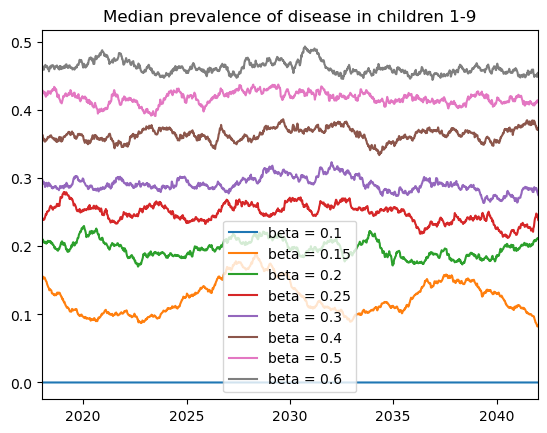

In [239]:
import matplotlib.pyplot as plt
start_year = 2010-burnin/52 # was 2018 - check to match csv dates

for beta in betas:
    plt.plot(start_year + np.array(res_bet[str(beta)][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_bet[str(beta)][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]))

plt.legend(['beta = ' + str(beta) for beta in betas]) 
plt.title("Median prevalence of disease in children 1-9")
plt.xlim([2018,2042])

(2018.0, 2042.0)

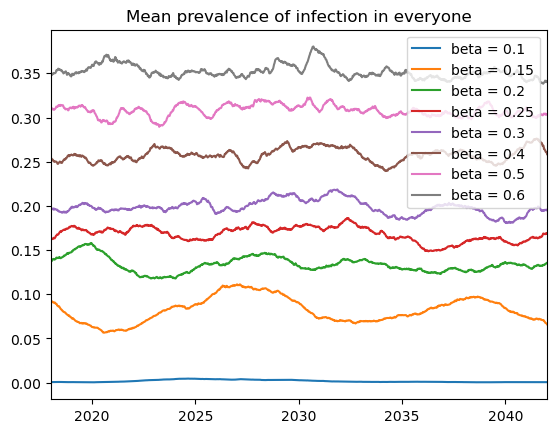

In [240]:
for beta in betas:
    plt.plot(start_year + np.array(res_bet[str(beta)][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_bet[str(beta)][0]['Mean_Infection_All'][(sim_params['burnin']-100): sim_params['timesim']]))
    
plt.legend(['beta = ' + str(beta) for beta in betas]) 
plt.title("Mean prevalence of infection in everyone")
plt.xlim([2018,2042])
#plt.xlim([2027, 2041])
#plt.ylim([0,0.05])

## 1/3/5 year MDA plans

In [64]:
# loading in each timescale of MDA
MDADataS1, MDA_timesS1 = get_MDA_data("survey1.csv")
VaccDataS1, vacc_timesS1 = get_vacc_data("survey1.csv")

MDADataS3, MDA_timesS3 = get_MDA_data("survey3.csv")
VaccDataS3, vacc_timesS3 = get_vacc_data("survey3.csv")

MDADataS5, MDA_timesS5 = get_MDA_data("survey5.csv")
VaccDataS5, vacc_timesS5 = get_vacc_data("survey5.csv")

In [65]:
# run one round of each treatment plan according to natural prevalence

res_surv = {}

# 1 round
beta = 0.12
data = SimulationFunction(params, sim_params, demog, MDA_timesS1, MDADataS1, vacc_timesS1, VaccDataS1, seed_bump = seed, beta = beta)
res_surv[str(beta)] = analyseResults(data, sim_params)
beta = 0.15
data = SimulationFunction(params, sim_params, demog, MDA_timesS1, MDADataS1, vacc_timesS1, VaccDataS1, seed_bump = seed, beta = beta)
res_surv[str(beta)] = analyseResults(data, sim_params)

# 3 rounds
beta = 0.2
data = SimulationFunction(params, sim_params, demog, MDA_timesS3, MDADataS3, vacc_timesS3, VaccDataS3, seed_bump = seed, beta = beta)
res_surv[str(beta)] = analyseResults(data, sim_params)
beta = 0.25
data = SimulationFunction(params, sim_params, demog, MDA_timesS3, MDADataS3, vacc_timesS3, VaccDataS3, seed_bump = seed, beta = beta)
res_surv[str(beta)] = analyseResults(data, sim_params)

# 5 rounds
beta = 0.4
data = SimulationFunction(params, sim_params, demog, MDA_timesS5, MDADataS5, vacc_timesS5, VaccDataS5, seed_bump = seed, beta = beta)
res_surv[str(beta)] = analyseResults(data, sim_params)
beta = 0.6
data = SimulationFunction(params, sim_params, demog, MDA_timesS5, MDADataS5, vacc_timesS5, VaccDataS5, seed_bump = seed, beta = beta)
res_surv[str(beta)] = analyseResults(data, sim_params)

In [66]:
surv_betas = [0.12, 0.15, 0.2, 0.25, 0.4, 0.6]
#surv_betas = [0.12, 0.2, 0.25, 0.4]
pors_surv = {}
for i in surv_betas:
    pors_surv[str(i)] = [res_surv[str(i)][1]]

pors_surv = pd.DataFrame(pors_surv)
pors_surv.index = ['POR']
pors_surv

,0.12,0.15,0.2,0.25,0.4,0.6
POR,0.42,0.96,0.96,1.0,1.0,1.0


(2018.0, 2042.0)

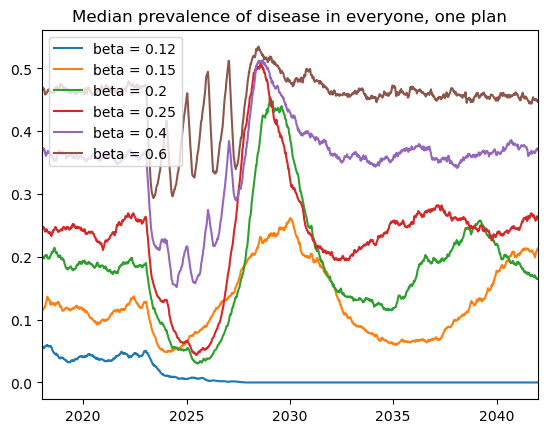

In [67]:
import matplotlib.pyplot as plt
start_year = 2010-burnin/52 # was 2018 - check to match csv dates

for beta in surv_betas:
    plt.plot(start_year + np.array(res_surv[str(beta)][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv[str(beta)][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]))

plt.legend(['beta = ' + str(beta) for beta in surv_betas]) 
plt.title("Median prevalence of disease in everyone, one plan")
plt.xlim([2018,2042])

(2018.0, 2042.0)

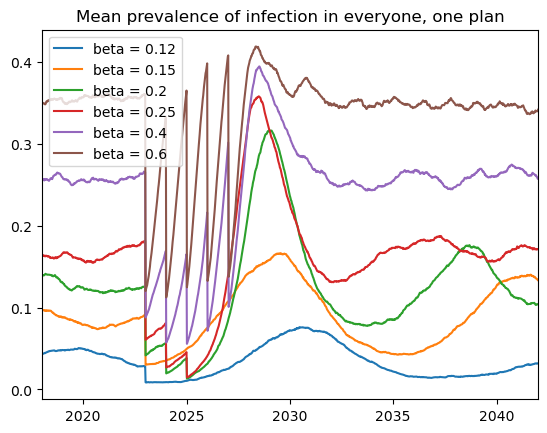

In [68]:
for beta in surv_betas:
    plt.plot(start_year + np.array(res_surv[str(beta)][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv[str(beta)][0]['Mean_Infection_All'][(sim_params['burnin']-100): sim_params['timesim']]))
    
plt.legend(['beta = ' + str(beta) for beta in surv_betas])
plt.title("Mean prevalence of infection in everyone, one plan")
plt.xlim([2018,2042])
#plt.xlim([2027, 2041])
#plt.ylim([0,0.05])

## 1/3/5 year plans with repeat after resurgence

In [69]:
# creating scenarios with secondary plans after resurgence (dates chosen based on the above graphs)
MDADataS1rep, MDA_timesS1rep = get_MDA_data("survey1rep.csv")
VaccDataS1rep, vacc_timesS1rep = get_vacc_data("survey1rep.csv")

MDADataS3rep, MDA_timesS3rep = get_MDA_data("survey3rep.csv")
VaccDataS3rep, vacc_timesS3rep = get_vacc_data("survey3rep.csv")

MDADataS5rep, MDA_timesS5rep = get_MDA_data("survey5rep.csv")
VaccDataS5rep, vacc_timesS5rep = get_vacc_data("survey5rep.csv")

In [70]:
# prevalence for different betas but multiple treatment plans according to natural endemic level
res_surv_rep = {}

# 1 round
beta = 0.12
data = SimulationFunction(params, sim_params, demog, MDA_timesS1rep, MDADataS1rep, vacc_timesS1rep, VaccDataS1rep, seed_bump = seed, beta = beta)
res_surv_rep[str(beta)] = analyseResults(data, sim_params)

# 3 rounds
beta = 0.2
data = SimulationFunction(params, sim_params, demog, MDA_timesS3rep, MDADataS3rep, vacc_timesS3rep, VaccDataS3rep, seed_bump = seed, beta = beta)
res_surv_rep[str(beta)] = analyseResults(data, sim_params)
beta = 0.25
data = SimulationFunction(params, sim_params, demog, MDA_timesS3rep, MDADataS3rep, vacc_timesS3rep, VaccDataS3rep, seed_bump = seed, beta = beta)
res_surv_rep[str(beta)] = analyseResults(data, sim_params)

# 5 rounds
beta = 0.4
data = SimulationFunction(params, sim_params, demog, MDA_timesS5rep, MDADataS5rep, vacc_timesS5rep, VaccDataS5rep, seed_bump = seed, beta = beta)
res_surv_rep[str(beta)] = analyseResults(data, sim_params)
beta = 0.6
data = SimulationFunction(params, sim_params, demog, MDA_timesS5rep, MDADataS5rep, vacc_timesS5rep, VaccDataS5rep, seed_bump = seed, beta = beta)
res_surv_rep[str(beta)] = analyseResults(data, sim_params)

In [71]:
surv_rep_betas = [0.12, 0.2, 0.25, 0.4, 0.6]
#surv_rep_betas = [0.12, 0.25, 0.4]
pors_surv_rep = {}
for i in surv_rep_betas:
    pors_surv_rep[str(i)] = [res_surv_rep[str(i)][1]]

pors_surv_rep = pd.DataFrame(pors_surv_rep)
pors_surv_rep.index = ['POR']
pors_surv_rep

,0.12,0.2,0.25,0.4,0.6
POR,0.46,0.96,1.0,1.0,1.0


(2020.0, 2045.0)

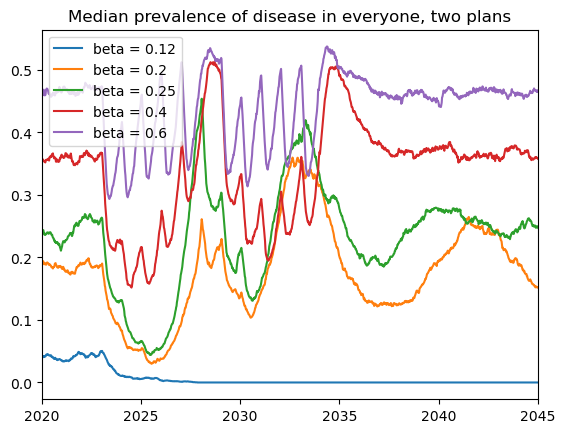

In [72]:
start_year = 2010-burnin/52 # was 2018 - check to match csv dates

for beta in surv_rep_betas:
    plt.plot(start_year + np.array(res_surv_rep[str(beta)][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_rep[str(beta)][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]))

plt.legend(['beta = ' + str(beta) for beta in surv_rep_betas]) 
plt.title("Median prevalence of disease in everyone, two plans")
plt.xlim([2020,2045])

(2020.0, 2045.0)

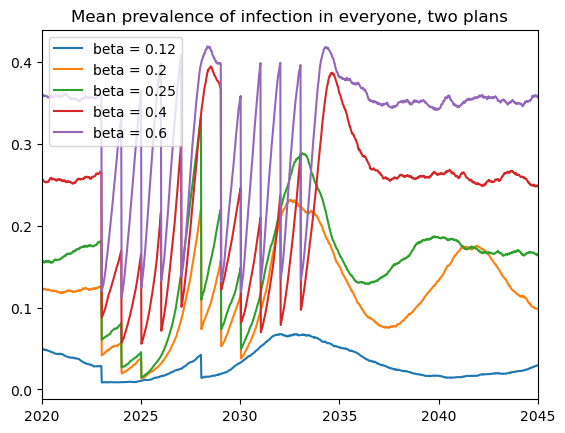

In [73]:
for beta in surv_rep_betas:
    plt.plot(start_year + np.array(res_surv_rep[str(beta)][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_rep[str(beta)][0]['Mean_Infection_All'][(sim_params['burnin']-100): sim_params['timesim']]))
    
plt.legend(['beta = ' + str(beta) for beta in surv_rep_betas]) 
plt.title("Mean prevalence of infection in everyone, two plans")
plt.xlim([2020,2045])
#plt.ylim([0,0.05])

## Comparing extra MDA round with vaccination - community-wide for now!

In [74]:
# creating scenarios with an extra round of MDA or one round of vaccination
MDADataS1m, MDA_timesS1m = get_MDA_data("survey1m.csv")
VaccDataS1m, vacc_timesS1m = get_vacc_data("survey1m.csv")
MDADataS1v, MDA_timesS1v = get_MDA_data("survey1v.csv")
VaccDataS1v, vacc_timesS1v = get_vacc_data("survey1v.csv")

MDADataS3m, MDA_timesS3m = get_MDA_data("survey3m.csv")
VaccDataS3m, vacc_timesS3m = get_vacc_data("survey3m.csv")
MDADataS3v, MDA_timesS3v = get_MDA_data("survey3v.csv")
VaccDataS3v, vacc_timesS3v = get_vacc_data("survey3v.csv")

MDADataS5m, MDA_timesS5m = get_MDA_data("survey5m.csv")
VaccDataS5m, vacc_timesS5m = get_vacc_data("survey5m.csv")
MDADataS5v, MDA_timesS5v = get_MDA_data("survey5v.csv")
VaccDataS5v, vacc_timesS5v = get_vacc_data("survey5v.csv")

In [75]:
# vaccination parameters
params['vacc_prob_block_transmission'] = 0.9
params['vacc_waning_length'] = 5 * 52

In [76]:
# prevalence for different betas but multiple treatment plans according to natural endemic level
res_surv_comp = {}

# low prevalence
beta = 0.12
data = SimulationFunction(params, sim_params, demog, MDA_timesS1m, MDADataS1m, vacc_timesS1m, VaccDataS1m, seed_bump = seed, beta = beta)
res_surv_comp['0.12, m'] = analyseResults(data, sim_params)
data = SimulationFunction(params, sim_params, demog, MDA_timesS1v, MDADataS1v, vacc_timesS1v, VaccDataS1v, seed_bump = seed, beta = beta)
res_surv_comp['0.12, v'] = analyseResults(data, sim_params)

# medium prevalence - consider 0.2-0.3 range
beta = 0.25
data = SimulationFunction(params, sim_params, demog, MDA_timesS3m, MDADataS3m, vacc_timesS3m, VaccDataS3m, seed_bump = seed, beta = beta)
res_surv_comp['0.25, m'] = analyseResults(data, sim_params)
data = SimulationFunction(params, sim_params, demog, MDA_timesS3v, MDADataS3v, vacc_timesS3v, VaccDataS3v, seed_bump = seed, beta = beta)
res_surv_comp['0.25, v'] = analyseResults(data, sim_params)

# high prevalence - consider 0.5+ instead for extreme case
beta = 0.4
data = SimulationFunction(params, sim_params, demog, MDA_timesS5m, MDADataS5m, vacc_timesS5m, VaccDataS5m, seed_bump = seed, beta = beta)
res_surv_comp['0.4, m'] = analyseResults(data, sim_params)
data = SimulationFunction(params, sim_params, demog, MDA_timesS5v, MDADataS5v, vacc_timesS5v, VaccDataS5v, seed_bump = seed, beta = beta)
res_surv_comp['0.4, v'] = analyseResults(data, sim_params)

## Plotting comparison - need res_surv, res_surv_comp and res_surv_rep

In [77]:
# Plotting LOW prevalence graphs - 1 plan, extra MDA, extra vaccination (add 2 plan in?)

In [78]:
pors_comp_012 = {}
pors_comp_012['Baseline'], pors_comp_012['Resurgence plan'] = [res_surv['0.12'][1]], [res_surv_rep['0.12'][1]]
pors_comp_012['MDA'], pors_comp_012['Vaccine'] = [res_surv_comp['0.12, m'][1]], [res_surv_comp['0.12, v'][1]]
pors_comp_012 = pd.DataFrame(pors_comp_012)
pors_comp_012.index = ['POR']
pors_comp_012

,Baseline,Resurgence plan,MDA,Vaccine
POR,0.42,0.46,0.38,0.0


(-0.005, 0.06)

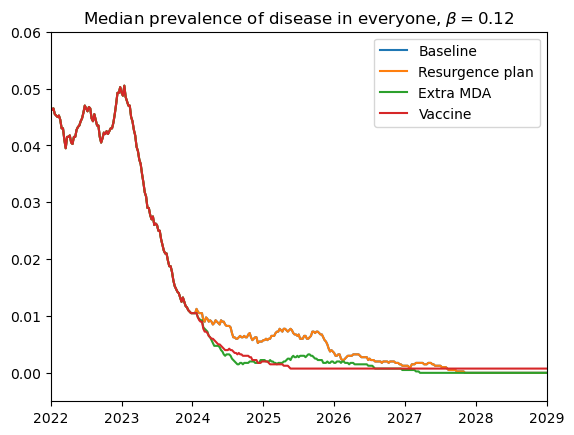

In [104]:
plt.plot(start_year + np.array(res_surv['0.12'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv['0.12'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Baseline')
plt.plot(start_year + np.array(res_surv_rep['0.12'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_rep['0.12'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Resurgence plan')
plt.plot(start_year + np.array(res_surv_comp['0.12, m'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.12, m'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Extra MDA')
plt.plot(start_year + np.array(res_surv_comp['0.12, v'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.12, v'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine')
    
plt.legend()
plt.title(r"Median prevalence of disease in everyone, $\beta = 0.12$")
plt.xlim([2020,2045])
plt.xlim([2022,2029])
plt.ylim([-0.005, 0.06])
#plt.xlim([2020, 2100])
#plt.ylim([0,0.03])

In [80]:
# Plotting MEDIUM prevalence graphs - 1 plan, extra MDA, extra vaccination (add 2 plan in?)

In [81]:
pors_comp_025 = {}
pors_comp_025['Baseline'], pors_comp_025['Resurgence plan'] = [res_surv['0.25'][1]], [res_surv_rep['0.25'][1]]
pors_comp_025['MDA'], pors_comp_025['Vaccine'] = [res_surv_comp['0.25, m'][1]], [res_surv_comp['0.25, v'][1]]
pors_comp_025 = pd.DataFrame(pors_comp_025)
pors_comp_025.index = ['POR']
pors_comp_025

,Baseline,Resurgence plan,MDA,Vaccine
POR,1.0,1.0,1.0,0.04


(2020.0, 2037.0)

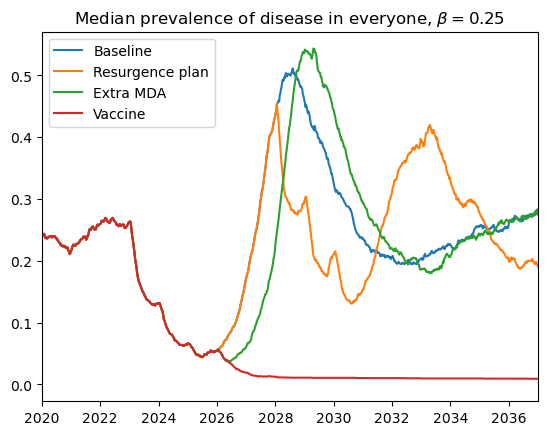

In [107]:
plt.plot(start_year + np.array(res_surv['0.25'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv['0.25'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Baseline')
plt.plot(start_year + np.array(res_surv_rep['0.25'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_rep['0.25'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Resurgence plan')
plt.plot(start_year + np.array(res_surv_comp['0.25, m'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.25, m'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Extra MDA')
plt.plot(start_year + np.array(res_surv_comp['0.25, v'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.25, v'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine')
    
plt.legend()
plt.title(r"Median prevalence of disease in everyone, $\beta = 0.25$")
plt.xlim([2020,2037])
#plt.xlim([2020,2100])
#plt.ylim([0,0.05])

In [83]:
# Plotting HIGH prevalence graphs - 1 plan, extra MDA, extra vaccination (add 2 plan in?)

In [84]:
pors_comp_04 = {}
pors_comp_04['Baseline'], pors_comp_04['Resurgence plan'] = [res_surv['0.4'][1]], [res_surv_rep['0.4'][1]]
pors_comp_04['MDA'], pors_comp_04['Vaccine'] = [res_surv_comp['0.4, m'][1]], [res_surv_comp['0.4, v'][1]]
pors_comp_04 = pd.DataFrame(pors_comp_04)
pors_comp_04.index = ['POR']
pors_comp_04

,Baseline,Resurgence plan,MDA,Vaccine
POR,1.0,1.0,1.0,0.74


(2020.0, 2045.0)

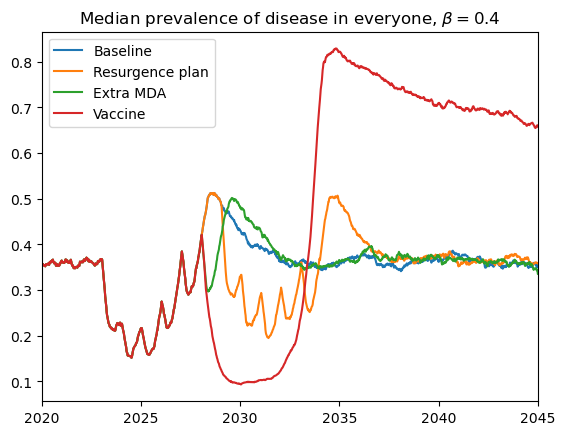

In [85]:
plt.plot(start_year + np.array(res_surv['0.4'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv['0.4'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Baseline')
plt.plot(start_year + np.array(res_surv_rep['0.4'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_rep['0.4'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Resurgence plan')
plt.plot(start_year + np.array(res_surv_comp['0.4, m'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.4, m'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Extra MDA')
plt.plot(start_year + np.array(res_surv_comp['0.4, v'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.4, v'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine')
    
plt.legend()
plt.title(r"Median prevalence of disease in everyone, $\beta = 0.4$")
plt.xlim([2020,2045])
#plt.xlim([2020,2100])
#plt.ylim([0,0.05])

## More lenient or intense strategies (omit baseline + resurgence for cleaner graph!)

In [86]:
# low prevalence - try child-only or a 1 year delay instead

In [87]:
beta = 0.12
MDADataS1vco, MDA_timesS1vco = get_MDA_data("survey1vco.csv")
VaccDataS1vco, vacc_timesS1vco = get_vacc_data("survey1vco.csv")
MDADataS1vd, MDA_timesS1vd = get_MDA_data("survey1vd.csv")
VaccDataS1vd, vacc_timesS1vd = get_vacc_data("survey1vd.csv")
data = SimulationFunction(params, sim_params, demog, MDA_timesS1vco, MDADataS1vco, vacc_timesS1vco, VaccDataS1vco, seed_bump = seed, beta = beta)
res_surv_comp['0.12, v, co'] = analyseResults(data, sim_params)
data = SimulationFunction(params, sim_params, demog, MDA_timesS1vd, MDADataS1vd, vacc_timesS1vd, VaccDataS1vd, seed_bump = seed, beta = beta)
res_surv_comp['0.12, v, d'] = analyseResults(data, sim_params)

In [88]:
pors_comp_012 = {}
pors_comp_012['Baseline'], pors_comp_012['Resurgence plan'] = [res_surv['0.12'][1]], [res_surv_rep['0.12'][1]]
pors_comp_012['MDA'], pors_comp_012['Vaccine'] = [res_surv_comp['0.12, m'][1]], [res_surv_comp['0.12, v'][1]]
pors_comp_012['Vaccine, CO'], pors_comp_012['Vaccine, delay'] = [res_surv_comp['0.12, v, co'][1]], [res_surv_comp['0.12, v, d'][1]]
pors_comp_012 = pd.DataFrame(pors_comp_012)
pors_comp_012.index = ['POR']
pors_comp_012

,Baseline,Resurgence plan,MDA,Vaccine,"Vaccine, CO","Vaccine, delay"
POR,0.42,0.46,0.38,0.0,0.14,0.0


(0.0, 0.06)

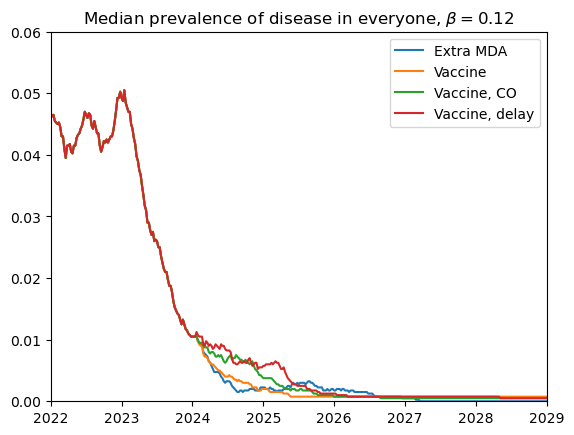

In [112]:
#plt.plot(start_year + np.array(res_surv['0.12'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv['0.12'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Baseline')
#plt.plot(start_year + np.array(res_surv_rep['0.12'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_rep['0.12'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Resurgence plan')
plt.plot(start_year + np.array(res_surv_comp['0.12, m'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.12, m'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Extra MDA')
plt.plot(start_year + np.array(res_surv_comp['0.12, v'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.12, v'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine')
plt.plot(start_year + np.array(res_surv_comp['0.12, v, co'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.12, v, co'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine, CO')
plt.plot(start_year + np.array(res_surv_comp['0.12, v, d'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.12, v, d'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine, delay')

plt.legend()
plt.title(r"Median prevalence of disease in everyone, $\beta = 0.12$")
plt.xlim([2020,2045])
plt.xlim([2022,2029])
#plt.xlim([2020, 2100])
plt.ylim([0,0.06])

In [131]:
# mid prevalence - try child-only or a 1 year delay instead.
# I added a scenario with 2 consecutive child-only rounds, to compare this with one round of community-wide

In [91]:
beta = 0.25
MDADataS3vco, MDA_timesS3vco = get_MDA_data("survey3vco.csv")
VaccDataS3vco, vacc_timesS3vco = get_vacc_data("survey3vco.csv")
MDADataS3vd, MDA_timesS3vd = get_MDA_data("survey3vd.csv")
VaccDataS3vd, vacc_timesS3vd = get_vacc_data("survey3vd.csv")
data = SimulationFunction(params, sim_params, demog, MDA_timesS3vco, MDADataS3vco, vacc_timesS3vco, VaccDataS3vco, seed_bump = seed, beta = beta)
res_surv_comp['0.25, v, co'] = analyseResults(data, sim_params)
data = SimulationFunction(params, sim_params, demog, MDA_timesS3vd, MDADataS3vd, vacc_timesS3vd, VaccDataS3vd, seed_bump = seed, beta = beta)
res_surv_comp['0.25, v, d'] = analyseResults(data, sim_params)

In [116]:
# quickly comparing 2 years of child-only vaccination with one year of community-wide
beta = 0.25
MDADataS3vco2, MDA_timesS3vco2 = get_MDA_data("survey3vco2.csv")
VaccDataS3vco2, vacc_timesS3vco2 = get_vacc_data("survey3vco2.csv")
data = SimulationFunction(params, sim_params, demog, MDA_timesS3vco2, MDADataS3vco2, vacc_timesS3vco2, VaccDataS3vco2, seed_bump = seed, beta = beta)
res_surv_comp['0.25, v, co2'] = analyseResults(data, sim_params)

In [117]:
pors_comp_025 = {}
pors_comp_025['Baseline'], pors_comp_025['Resurgence plan'] = [res_surv['0.25'][1]], [res_surv_rep['0.25'][1]]
pors_comp_025['MDA'], pors_comp_025['Vaccine'] = [res_surv_comp['0.25, m'][1]], [res_surv_comp['0.25, v'][1]]
pors_comp_025['Vaccine, CO'], pors_comp_025['Vaccine, COx2'] = [res_surv_comp['0.25, v, co'][1]], [res_surv_comp['0.25, v, co2'][1]]
pors_comp_025['Vaccine, delay'] = [res_surv_comp['0.25, v, d'][1]]
pors_comp_025 = pd.DataFrame(pors_comp_025)
pors_comp_025.index = ['POR']
pors_comp_025

,Baseline,Resurgence plan,MDA,Vaccine,"Vaccine, CO","Vaccine, COx2","Vaccine, delay"
POR,1.0,1.0,1.0,0.04,0.42,0.0,0.3


(2024.0, 2031.0)

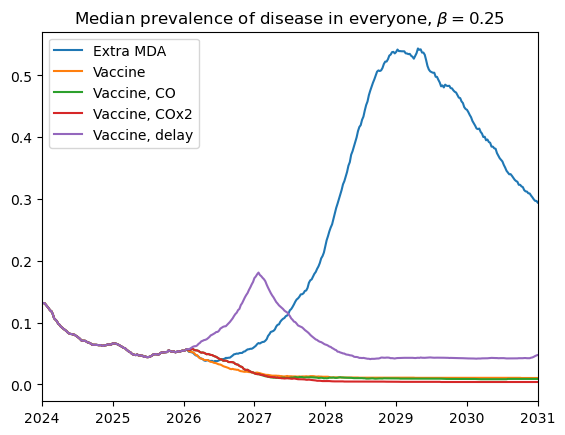

In [130]:
#plt.plot(start_year + np.array(res_surv['0.25'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv['0.25'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Baseline')
#plt.plot(start_year + np.array(res_surv_rep['0.25'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_rep['0.25'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Resurgence plan')
plt.plot(start_year + np.array(res_surv_comp['0.25, m'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.25, m'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Extra MDA')
plt.plot(start_year + np.array(res_surv_comp['0.25, v'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.25, v'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine')
plt.plot(start_year + np.array(res_surv_comp['0.25, v, co'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.25, v, co'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine, CO')
plt.plot(start_year + np.array(res_surv_comp['0.25, v, co2'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.25, v, co2'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine, COx2')
plt.plot(start_year + np.array(res_surv_comp['0.25, v, d'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.25, v, d'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine, delay')

plt.legend()
plt.title(r"Median prevalence of disease in everyone, $\beta = 0.25$")
plt.xlim([2024,2031])
#plt.xlim([2020, 2100])
#plt.ylim([0,0.2])

In [94]:
# high prevalence - try an extra round after 2 or 5 years

In [95]:
beta = 0.4
MDADataS5v2, MDA_timesS5v2 = get_MDA_data("survey5v2.csv")
VaccDataS5v2, vacc_timesS5v2 = get_vacc_data("survey5v2.csv")
MDADataS5v5, MDA_timesS5v5 = get_MDA_data("survey5v5.csv")
VaccDataS5v5, vacc_timesS5v5 = get_vacc_data("survey5v5.csv")
data = SimulationFunction(params, sim_params, demog, MDA_timesS5v2, MDADataS5v2, vacc_timesS5v2, VaccDataS5v2, seed_bump = seed, beta = beta)
res_surv_comp['0.4, v, 2'] = analyseResults(data, sim_params)
data = SimulationFunction(params, sim_params, demog, MDA_timesS5v5, MDADataS5v5, vacc_timesS5v5, VaccDataS5v5, seed_bump = seed, beta = beta)
res_surv_comp['0.4, v, 5'] = analyseResults(data, sim_params)

In [96]:
pors_comp_04 = {}
pors_comp_04['Baseline'], pors_comp_04['Resurgence plan'] = [res_surv['0.4'][1]], [res_surv_rep['0.4'][1]]
pors_comp_04['MDA'], pors_comp_04['Vaccine'] = [res_surv_comp['0.4, m'][1]], [res_surv_comp['0.4, v'][1]]
pors_comp_04['Vaccine, 2y'], pors_comp_04['Vaccine, 5y'] = [res_surv_comp['0.4, v, 2'][1]], [res_surv_comp['0.4, v, 5'][1]]
pors_comp_04 = pd.DataFrame(pors_comp_04)
pors_comp_04.index = ['POR']
pors_comp_04

,Baseline,Resurgence plan,MDA,Vaccine,"Vaccine, 2y","Vaccine, 5y"
POR,1.0,1.0,1.0,0.74,0.04,0.6


(2020.0, 2045.0)

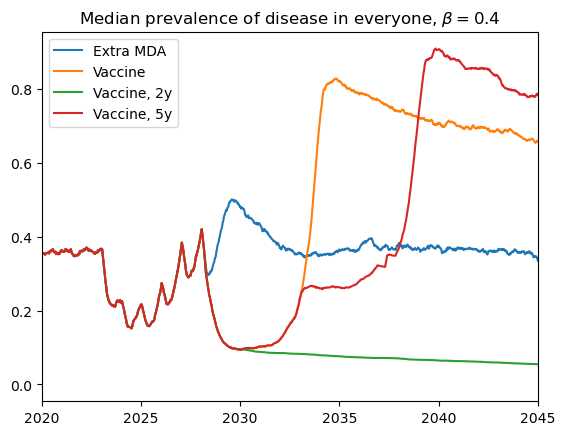

In [97]:
#plt.plot(start_year + np.array(res_surv['0.4'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv['0.4'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Baseline')
#plt.plot(start_year + np.array(res_surv_rep['0.4'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_rep['0.4'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Resurgence plan')
plt.plot(start_year + np.array(res_surv_comp['0.4, m'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.4, m'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Extra MDA')
plt.plot(start_year + np.array(res_surv_comp['0.4, v'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.4, v'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine')
plt.plot(start_year + np.array(res_surv_comp['0.4, v, 2'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.4, v, 2'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine, 2y')
plt.plot(start_year + np.array(res_surv_comp['0.4, v, 5'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_surv_comp['0.4, v, 5'][0]['Median_Disease_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Vaccine, 5y')
         
plt.legend()
plt.title(r"Median prevalence of disease in everyone, $\beta = 0.4$")
plt.xlim([2020,2045])
#plt.xlim([2020,2100])
#plt.ylim([0,0.05])